# drlnd Project 3: Collaboration and Competition - Tennis

---

https://github.com/sliao-mi-luku/DeepRL-multiple-agents-tennis-udacity-drlnd-p3

Reinforcement learning environment by Unity ML-Agents

This corresponds to **Project #3** of Udacity's Deep Reinforcement Learning Nanodegree (drlnd)

https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893

The multi-agent deep deterministic policy gradient (MADDPG) method is implemented in this project

**Reference**: this code was inspired by:

1. Udacity's GitHub repository **ddpg-pendulum**

   https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum


2. Udacity's drlnd project workspace (jupyter notebook) of **Project: Collaboration and Competition**


3. Udacity's drlnd MADDPG-Lab


## Box 1: Starting the environment

Run the box below to import necessary packages.

In the command env = UnityEnvironment(file_name = '...') paste the path to **Tennis.exe**

For example: `env = UnityEnvironment(file_name = './Tennis_Windows_x86_64/Tennis.exe')`

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
from unityagents import UnityEnvironment
from maddpgAgent import MADDPG_Agent
from buffer import Buffer
from noiseModels import OUNoise, plot_OU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\nDevice: {}".format(device))


"""
paste the path to Tennis.exe below
"""
# env = UnityEnvironment(file_name = "/the/path/to/Tennis.exe")
env = UnityEnvironment(file_name = "./Tennis_Windows_x86_64/Tennis.exe")


"""
Environments contain brains which are responsible for deciding the actions of their associated agents
"""
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


"""
The codes below were provided by Udacity, which will display some information of the environment
"""
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


print("\nBox 1 done!")


Device: cuda:0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]

Box 1 done!


## Box 2 - Hyperparameters

Run this box to set the parameters

In [2]:
EPISODES = 5000                   # maximum number of episodes to train

PRINT_EVERY = 200                 # print a new line of information every 200 episodes


## hyperparameters
actor_hidden_sizes = [400, 300]   # input and output sizes of the actor's hidden FC layer
critic_hidden_sizes = [400, 300]  # input and output sizes of the critic's hidden FC layer
gamma = 0.99                      # discounting
actor_lr = 1e-4                   # learning rate of the actor network
critic_lr = 1e-3                  # learning rate of the critic network
critic_L2_decay = 0               # L2 weight decay of the critic network
tau = 1e-3                        # the factor used for soft-updating actor/critic target networks


## parameters of the noise (Ornstein–Uhlenbeck) process
ou_scale = 1.0                    # initial scaling factor
ou_decay = 0.9995                 # decay of the scaling factor ou_scale
ou_mu = 0.0                       # asymptotic mean of the noise
ou_theta = 0.15                   # magnitude of the drift term
ou_sigma = 0.20                   # magnitude of the diffusion term


## parameters of the replay buffer
buffer_size = int(1e5)            # size of the buffer
batch_size = 128                  # size of the sampling batch


## Dictionary to pass into the MADDPG_Agent to create the agent
config = {}
config['actor_input_size'] = 24                         # dimension of the state (for each agent)
config['actor_output_size'] = 2                         # dimension of the action (for each agent)
config['actor_hidden_sizes'] = actor_hidden_sizes
config['critic_state_size'] = 48                        # dimension of the state (for both agents)
config['critic_action_size'] = 4                        # dimension of the action (for both agents)
config['critic_hidden_sizes'] = critic_hidden_sizes
config['actor_lr'] = actor_lr
config['critic_lr'] = critic_lr
config['critic_L2_decay'] = critic_L2_decay
config['gamma'] = gamma
config['tau'] = tau


print("\n Box 2 done!")


 Box 2 done!


## Box 3 - Multi-Agent Deep Deterministic Policy Gradient (MADDPG)

Run this box to train the agent

Simulation of the noise Process:


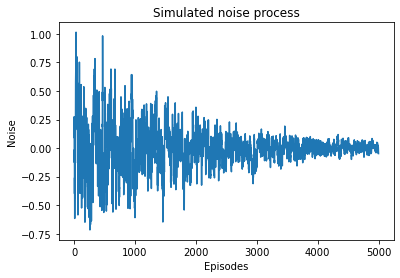



Episode 200	Score: 0.00	Avg: 0.00	|ou|: 0.182
Episode 400	Score: 0.00	Avg: 0.03	|ou|: 0.158
Episode 600	Score: 0.10	Avg: 0.07	|ou|: 0.244
Episode 800	Score: 0.00	Avg: 0.11	|ou|: 0.176
Episode 941	Score: 2.10	Avg: 0.51	|ou|: 0.228
Environment is solved after 841 episodes



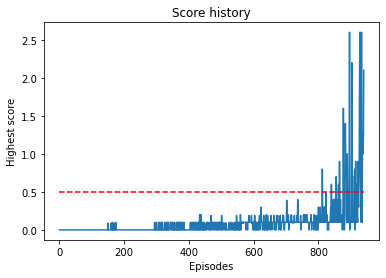

In [3]:
## MADDPG

score_deque = deque(maxlen = 100)    # keep the maximum score over the agents in the past 100 episodes
score_list = [[], []]                # keep the score of each agent
max_score_list = []                  # keep the higher score in the episode

# create the replay buffer
buffer = Buffer(buffer_size, batch_size)

# create the maddpg agents
# the index of the agents are 0 and 1
agents = [MADDPG_Agent(0, config), MADDPG_Agent(1, config)]

# create the noise process
noise_process = OUNoise(4, ou_mu, ou_theta, ou_sigma)

# simulation of the noisen
# note that the sampling in this simulation is independent of the sampling during the maddpg training
print("Simulation of the noise Process:")
plot_OU(EPISODES, ou_scale, ou_decay, 1, ou_mu, ou_theta, ou_sigma)
print("\n")

for ep in range(1, EPISODES+1):

    # env information
    env_info = env.reset(train_mode = True)[brain_name]

    # initial state. env provides the states with the shape (2, 24), reshape it to (1, 48)
    states = env_info.vector_observations.reshape((1, 48))
    
    # scores for each agents
    scores = np.zeros(2)  # ndarray shape (2, )

    # time steps
    t_step = 0 

    while True:
        t_step += 1

        """
        Data collection
        """
        # split into the states into the parts observed by each agent (ndarray)
        states_0 = states[0, :24].reshape((1, 24))  # ndarray shape (1, 24)
        states_1 = states[0, 24:].reshape((1, 24))  # ndarray shape (1, 24)
        
        # convert the states into tensors
        states_0_t = torch.from_numpy(states_0).float().to(device)
        states_1_t = torch.from_numpy(states_1).float().to(device)

        # generate noise (ndarray)
        noise = ou_scale * noise_process.get_noise().reshape((1, 4)) # ndarray shape (1, 4)
        noise_avgabs = np.round(np.mean(np.abs(noise[0,:])), 3)      # see the average |noise| generated
        # split the noise into the parts for each agent
        noise_0 = noise[0, :2].reshape((1, 2))  # ndarray shape (1, 2)
        noise_1 = noise[0, 2:].reshape((1, 2))  # ndarray shape (1, 2)

        # decide actions by actor_local, convert to ndarray
        actions_0 = agents[0].act(states_0_t, 'local', True, noise_0).detach().cpu().numpy() # agent 0
        actions_1 = agents[1].act(states_1_t, 'local', True, noise_1).detach().cpu().numpy() # agent 1
        actions = np.vstack((actions_0, actions_1)) # ndarray shape (2, 2)

        # use the actions to interact with the environment
        env_info = env.step(actions)[brain_name]                    # env info
        next_states = env_info.vector_observations.reshape(1, 48)   # next states, converted to ndarray shape (1, 48)
        rewards = np.array(env_info.rewards)                        # ndarray shape (2, )
        dones = np.array(env_info.local_done)                       # ndarray shape (2, )

        ## push into buffer
        # states.flatten()       # ndarray shape (48, )
        # actions.flatten()      # ndarray shape (4, )
        # rewards                # ndarray shape (2, )
        # next_states.flatten()  # ndarray shape (48, )
        # dones                  # ndarray shape (2, )
        buffer.add(states.flatten(), actions.flatten(), rewards, next_states.flatten(), dones)
        
        # update scores of each agent
        scores += rewards
            
        # advance to th next state
        states = next_states


        """
        Policy learning
        """
        ## train the agents if we have enough replays in the buffer
        if len(buffer) >= batch_size:
            # agent 0
            agents[0].learn(buffer.sample(), agents[1])  # train Agent 0
            # agent 1
            agents[1].learn(buffer.sample(), agents[0])  # train Agent 1

        # end the episode if at least one agent is in the terminal state
        if np.any(dones):
            break


    # keep scores
    score_list[0].append(scores[0])
    score_list[1].append(scores[1])
    score_deque.append(scores.max())
    max_score_list.append(scores.max())

    # average score of the past 100 episodes
    AVG_100 = np.mean(score_deque)

    # print the information
    print("\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\t|ou|: {:.3f}".format(
        ep, scores.max(), AVG_100, noise_avgabs), end="")

    # print a new line for every PRINT_EVERY epiodes
    if ep % PRINT_EVERY == 0:
        print("\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\t|ou|: {:.3f}".format(
            ep, scores.max(), AVG_100, noise_avgabs))

    # the condition when the task is considered solved
    if AVG_100 > 0.5 and len(score_deque) >= 100:
        print("\nEnvironment is solved after {} episodes\n".format(ep - 100))
        break
    
    # decrease the scaling factor of the noise
    ou_scale *= ou_decay


    
## Save the weights
torch.save(agents[0].actor_local.state_dict(), 'checkpoint_actor_0.pth')
torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic_0.pth')
torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor_1.pth')
torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic_1.pth')


## Plot the score of each episode
plt.figure()
plt.plot(range(len(max_score_list)), max_score_list)
plt.plot([0, len(max_score_list)-1], [0.5, 0.5], 'r--')
plt.title("Score history")
plt.xlabel("Episodes")
plt.ylabel("Highest score")
plt.show()

## Box 4: Loading trained weights

Run the box below to use the pre-trained weights to watch the agents hit some volleys

In [4]:
## Test the saved weights

# create the maddpg agents
agents = [MADDPG_Agent(0, config), MADDPG_Agent(1, config)]

# load the pre-trained weights from the working directory (change the file name if needed)

agents[0].actor_local.load_state_dict(torch.load('checkpoint_actor_0.pth'))      # Agent 0: actor
agents[0].critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth'))    # Agent 0: critic

agents[1].actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth'))      # Agent 1: actor
agents[1].critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))    # Agent 1: critic


# initialize the environment
env_info = env.reset(train_mode = False)[brain_name]

# initial state. env provides the states with the shape (2, 24), reshape it to (1, 48)
states = env_info.vector_observations.reshape((1, 48))

# scores of the agents
scores = [0, 0]

while True:
    # split into the states into the parts observed by each agent (ndarray)
    states_0 = states[0, :24] 
    states_1 = states[0, 24:]

    # convert the states into tensors
    states_0_t = torch.from_numpy(states_0).float().to(device)
    states_1_t = torch.from_numpy(states_1).float().to(device)


    # decide actions by actor_local, convert to ndarray
    actions_0 = agents[0].act(states_0_t, 'local', False).detach().cpu().numpy()   # Agent 0
    actions_1 = agents[1].act(states_1_t, 'local', False).detach().cpu().numpy()   # Agent 1
    actions = np.vstack((actions_0, actions_1)) # shape (2, 2)

    # use the actions to interact with the environment
    env_info = env.step(actions)[brain_name]                     # env info
    next_states = env_info.vector_observations.reshape((1, 48))  # next states, converted to ndarray shape (1, 48)
    rewards = env_info.rewards                                   # rewards, list of len = 2
    dones = env_info.local_done                                  # dones, list of len = 2

    # update scores of each agent
    scores[0] += rewards[0]
    scores[1] += rewards[1]

    # advance to th next state
    states = next_states
    
    # break if entering a terminal state
    if np.any(dones):
        break
        
        
print('Total score (max over the players) this episode: {:.2f}'.format(max(scores)))

Total score (max over the players) this episode: 2.40


Lastly, please run the command below to close the environment

In [5]:
env.close()

## References

Papers:

1. R. Lowe et al., 2017. *Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments*

    https://arxiv.org/abs/1706.02275 (MADDPG)


2. T. P. Lillicrap et al., 2016. *Continuous control with deep reinforcement learning*

    https://arxiv.org/abs/1509.02971 (DDPG)


This code was inspired by:

1. Udacity's GitHub repository **ddpg-pendulum** (ddpg_agent.py)

    https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum


2. Udacity's jupyter notebook template of **Project: Collaboration and Competition**


3. Udacity's drlnd MADDPG-Lab